#### Universal ELO Model

In this notebook, we try to create a universal ELO model, a la 538.

In [1]:
import os
import pandas as pd
from tennis_new.fetch.defs import STORED_DATA_PATH

#### Mess Around With Data

In [2]:
jd = pd.read_csv(
    os.path.join(STORED_DATA_PATH, 'joined.tsv'),
    sep='\t'
)

/Users/siddhantjagadish/Documents/DataProjects/tennis_new/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13,17,19,33,39,40,41,42,43,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
jd.shape

(198106, 48)

In [4]:
ELO_REL_COLUMNS = [
    'match_id',
    'winner_name',
    'loser_name',
    'winner_player_id',
    'loser_player_id',
    'tourney_surface',
    'tourney_year',
    'tourney_month',
    'tourney_day',
    'round_order',
    'match_order',
    'tourney_round_name',
    'tourney_name'
]
jd[ELO_REL_COLUMNS].head()

,match_id,winner_name,loser_name,winner_player_id,loser_player_id,tourney_surface,tourney_year,tourney_month,tourney_day,round_order,match_order,tourney_round_name,tourney_name
0,2016-451-d643-n409,Novak Djokovic,Rafael Nadal,d643,n409,Hard,2016,1.0,4.0,1,1,Finals,Brisbane
1,2016-451-d643-ba47,Novak Djokovic,Tomas Berdych,d643,ba47,Hard,2016,1.0,4.0,2,1,Semi-Finals,Brisbane
2,2016-451-n409-me89,Rafael Nadal,Illya Marchenko,n409,me89,Hard,2016,1.0,4.0,2,2,Semi-Finals,Brisbane
3,2016-451-d643-md56,Novak Djokovic,Leonardo Mayer,d643,md56,Hard,2016,1.0,4.0,3,1,Quarter-Finals,Brisbane
4,2016-451-n409-kb54,Rafael Nadal,Andrey Kuznetsov,n409,kb54,Hard,2016,1.0,4.0,3,2,Quarter-Finals,Brisbane


In [10]:
# Sort data so we can update appropriately
# TODO: This should be done in the creation of the joined?

# Sorting columns should never be null
sort_cols = [
    'tourney_year', 'tourney_month', 'tourney_day', 'round_order', 'match_order'
]
for col in sort_cols:
    assert jd[col].notnull().all()

jd.sort_values(
    ['tourney_year', 'tourney_month', 'tourney_day', 'round_order', 'match_order'],
    ascending=[True, True, True, False, True],
    inplace=True
)
jd[ELO_REL_COLUMNS].head()

,match_id,winner_name,loser_name,winner_player_id,loser_player_id,tourney_surface,tourney_year,tourney_month,tourney_day,round_order,match_order,tourney_round_name,tourney_name
13823,1877-540-e994-lh24,L. Erskine,J. Lambert,e994,lh24,Grass,1877,7.0,9.0,4,1,Round Robin,Wimbledon
13824,1877-540-gi91-hg46,Spencer Gore,M. Hankey,gi91,hg46,Grass,1877,7.0,9.0,4,2,Round Robin,Wimbledon
13825,1877-540-lh23-bt10,F. Langham,J. Baker,lh23,bt10,Grass,1877,7.0,9.0,4,3,Round Robin,Wimbledon
13826,1877-540-mu62-af58,William Marshall,B. Akroyd,mu62,af58,Grass,1877,7.0,9.0,4,4,Round Robin,Wimbledon
13827,1877-540-mu66-o628,J. Marshall,F. Oliver,mu66,o628,Grass,1877,7.0,9.0,4,5,Round Robin,Wimbledon


In [11]:
from tennis_new.ml.elo import ELOModel

elo = ELOModel(winner_mod=True)
elo.fit_and_backfill(
    jd['winner_name'].tolist(),
    jd['loser_name'].tolist(),
    jd['match_id'].tolist()
)

In [12]:
elo_preds = pd.DataFrame(elo.history)

In [13]:
together = pd.merge(
    jd,
    elo_preds,
    on='match_id'
)

In [14]:
# Top player-years of all-time
together.sort_values('elo1', ascending=False).drop_duplicates(['winner_name', 'tourney_year'])[[
    'winner_name', 'elo1', 'tourney_year'
]].head(20)

,winner_name,elo1,tourney_year
185208,Novak Djokovic,2618.113339,2016
184275,Novak Djokovic,2598.207088,2015
188622,Novak Djokovic,2560.325028,2017
178627,Novak Djokovic,2547.730451,2014
174918,Rafael Nadal,2525.219964,2013
172149,Novak Djokovic,2522.606206,2013
74187,John McEnroe,2519.516093,1985
73203,John McEnroe,2517.241843,1984
145086,Roger Federer,2514.054465,2007
58319,Bjorn Borg,2511.026926,1980


In [15]:
# Look at hold-out performance
test = together[
    (together['tourney_year'] > 2010)
]
test['tourney_year'].value_counts()

2012    4496
2011    4489
2015    4443
2013    4439
2014    4350
2016    4022
2017    3962
2018    3954
2019    1880
Name: tourney_year, dtype: int64

In [16]:
(test['elo_match_prediction'] > 0.5).mean()

0.665103371721937

67% accuracy since 2010

In [17]:
MAJORS = [
    'Wimbledon',
    'US Open',
    'Roland Garros',
    'Australian Open'
]

major_test = test[
    (test['tourney_name'].isin(MAJORS)) &
    (test['elo_match_prediction'] != 0.5)
]
major_test.groupby(['tourney_name', 'tourney_year']).apply(
    lambda x: (
        (x['elo_match_prediction'] > 0.5).mean(),
        x.shape[0]
    )
)

tourney_name     tourney_year
Australian Open  2011            (0.7112970711297071, 239)
                 2012            (0.6861924686192469, 239)
                 2013            (0.7071129707112971, 239)
                 2014            (0.6764705882352942, 238)
                 2015             (0.702928870292887, 239)
                 2016            (0.7364016736401674, 239)
                 2017            (0.7238493723849372, 239)
                 2018            (0.6317991631799164, 239)
                 2019            (0.7401574803149606, 127)
Roland Garros    2011            (0.6861924686192469, 239)
                 2012             (0.702928870292887, 239)
                 2013            (0.6932773109243697, 238)
                 2014            (0.6485355648535565, 239)
                 2015            (0.6820083682008368, 239)
                 2016             (0.698744769874477, 239)
                 2017            (0.6527196652719666, 239)
                 2018     

2018 tournaments were tough to predict...

#### Look at Players over Time

In [41]:
elo_preds['tourney_year'] = jd['tourney_year'].tolist()
elo_preds['tourney_month'] = jd['tourney_month'].tolist()
elo_preds['tourney_day'] = jd['tourney_day'].tolist()

In [81]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

def plot_player_over_time(pid):
    rel = elo_preds[
        (elo_preds['p1_id'] == pid) | (elo_preds['p2_id'] == pid)
    ]
    elos = rel[[
        'p1_id',
        'p2_id',
        'elo1',
        'elo2'
    ]].apply(
        lambda x: x['elo1'] if x['p1_id'] == pid else x['elo2'],
        axis=1
    )
    plt.plot(range(len(elos)), elos)
    _x = np.array(range(0, len(elos), 50))
    plt.xticks(
        _x.tolist(),
        rel['tourney_year'].iloc[_x].tolist(),
        rotation=90
    )

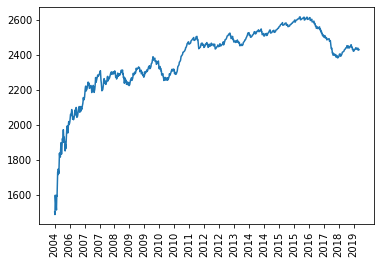

In [82]:
plot_player_over_time('Novak Djokovic')

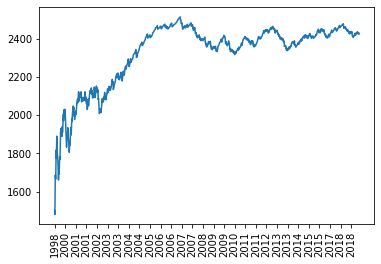

In [83]:
plot_player_over_time('Roger Federer')